[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
df = pd.read_csv("datasets/health_insurance.csv")


In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
# download the dataset from: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset
df = pd.read_csv("datasets/health_insurance.csv")

df[df.select_dtypes(['float64','int64']).columns] = (df[df.select_dtypes(['float64','int64']).columns] - df[df.select_dtypes(['float64','int64']).columns].mean()) / df[df.select_dtypes(['float64','int64']).columns].std()

# df = df.sample(n=10**5, random_state=43) # no need to sample when the dataset is so small


for feat in df.select_dtypes(['category']).columns:
    df[feat] = df[feat].values.codes

for feat in df.columns:
    num_new_feats = len(df[feat].unique())
    if df[feat].dtype != "float64" and df[feat].dtype!='int64':
        new_feats = OneHotEncoder(sparse=False).fit_transform(df[feat].values.reshape(-1,1))
        for idx in range(num_new_feats):
            df[f"{feat}_{idx}"] = new_feats[:,idx]
            df[f"{feat}_{idx}"] = df[f"{feat}_{idx}"].astype("float")
        del df[feat]


x = df.drop(columns="charges").values
y = df["charges"].values
print(x.shape, y.shape)

(1338, 11) (1338,)


In [8]:
n_samples = x.shape[0] # 10**5
n_feats = x.shape[1] # 10

In [9]:
# x = np.random.randn(n_samples, n_feats)
# w = np.random.randn(n_feats)
# y = x.dot(w) + 2*np.random.randn(n_samples)

In [10]:
y.min(), y.max()

(-1.0031822537315642, 4.170103954308559)

### Simple Linear Regression check

In [11]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([ 0.29800316,  0.17080621,  0.04733377,  0.00542173, -0.00542173,
       -0.98466195,  0.98466195,  0.04847305,  0.0193266 , -0.03699524,
       -0.03080441])

In [12]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.7509130345985207, 0.24890080175020768)

# Regress GAN

### Define ANN Architecture

In [13]:
# Batch size during training
batch_size = 64

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [14]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [15]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [16]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [18]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, network_width, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, network_width, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [19]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [20]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/100][0/13]	Loss_D: 1.4019	Loss_G: 0.6891	D(x): 0.4603	D(G(z)): 0.4643 / 0.5023
[1/100][0/13]	Loss_D: 1.2391	Loss_G: 0.8345	D(x): 0.5314	D(G(z)): 0.4482 / 0.4360
[2/100][0/13]	Loss_D: 1.3137	Loss_G: 0.8486	D(x): 0.5882	D(G(z)): 0.5075 / 0.4311
[3/100][0/13]	Loss_D: 1.2076	Loss_G: 0.8850	D(x): 0.6090	D(G(z)): 0.4623 / 0.4321
[4/100][0/13]	Loss_D: 1.4591	Loss_G: 0.7805	D(x): 0.4625	D(G(z)): 0.4893 / 0.4591
[5/100][0/13]	Loss_D: 1.3589	Loss_G: 0.7430	D(x): 0.5408	D(G(z)): 0.5008 / 0.4798
[6/100][0/13]	Loss_D: 1.2452	Loss_G: 0.8973	D(x): 0.5729	D(G(z)): 0.4486 / 0.4305
[7/100][0/13]	Loss_D: 1.3957	Loss_G: 0.7364	D(x): 0.4970	D(G(z)): 0.4949 / 0.4803
[8/100][0/13]	Loss_D: 1.6078	Loss_G: 0.6311	D(x): 0.4996	D(G(z)): 0.5635 / 0.5409
[9/100][0/13]	Loss_D: 1.4238	Loss_G: 0.6952	D(x): 0.4946	D(G(z)): 0.5020 / 0.5040
[10/100][0/13]	Loss_D: 1.3727	Loss_G: 0.7309	D(x): 0.4900	D(G(z)): 0.4811 / 0.4827
[11/100][0/13]	Loss_D: 1.3746	Loss_G: 0.7171	D(x): 0.4996	D(G(z)): 0.49

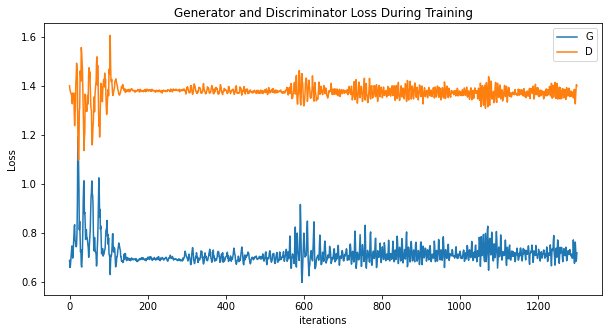

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

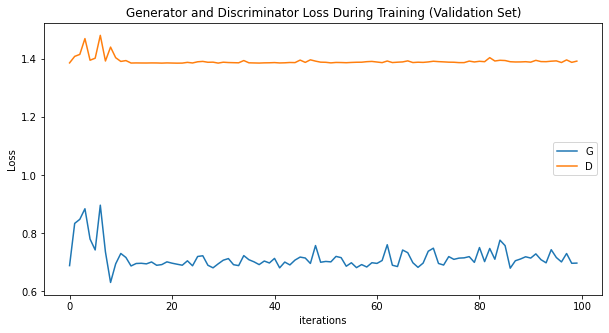

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [24]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [25]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [26]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,802.000000,802.000000
mean,-0.020810,-0.139694
std,1.001404,0.977712
min,-1.003182,-1.145011
25%,-0.720720,-0.787659
50%,-0.352065,-0.428938
75%,0.210536,-0.030237
max,4.170104,3.320538


In [27]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.146, -1.004]",-0.848188,-1.056582
"(-1.004, -0.84]",-0.739186,-0.920526
"(-0.84, -0.744]",-0.628554,-0.789293
"(-0.744, -0.587]",-0.495522,-0.663708
"(-0.587, -0.429]",-0.345509,-0.507425
"(-0.429, -0.26]",-0.120702,-0.341815
"(-0.26, -0.129]",-0.028078,-0.200659
"(-0.129, 0.294]",0.082469,0.014791
"(0.294, 1.418]",0.588603,0.720341


In [28]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.22330055, 1.0028106)

In [29]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.23818585, 0.7431162)

## Test Predictions

In [30]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [31]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [32]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,268.000000,268.000000
mean,0.065439,-0.075067
std,1.002904,0.989888
min,-1.002387,-1.162669
25%,-0.614853,-0.728155
50%,-0.259343,-0.361896
75%,0.461146,0.053259
max,3.457055,3.110346


In [33]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.164, -0.992]",-0.848734,-1.047700
"(-0.992, -0.777]",-0.457990,-0.876035
"(-0.777, -0.656]",-0.615260,-0.719510
"(-0.656, -0.5]",-0.446812,-0.589671
"(-0.5, -0.362]",-0.237280,-0.425717
"(-0.362, -0.248]",-0.197087,-0.309105
"(-0.248, -0.12]",-0.057081,-0.175289
"(-0.12, 0.551]",0.308973,0.106932
"(0.551, 1.481]",0.888345,0.911515


In [34]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.22521718, 1.0058161)

In [35]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.25798935, 0.77412707)

## Test Predictions (averaged)

In [36]:
N_SAMPLES = 100
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [37]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,268.000000,268.000000
mean,0.065439,-0.075420
std,1.002904,0.960518
min,-1.002387,-1.112745
25%,-0.614853,-0.688488
50%,-0.259343,-0.350547
75%,0.461146,-0.004276
max,3.457055,2.957417


In [38]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.1139999999999999, -0.915]",-0.824444,-0.998751
"(-0.915, -0.754]",-0.723079,-0.839231
"(-0.754, -0.649]",-0.393213,-0.689482
"(-0.649, -0.514]",-0.484275,-0.574691
"(-0.514, -0.351]",-0.269800,-0.415017
"(-0.351, -0.229]",-0.182758,-0.284355
"(-0.229, -0.0794]",-0.131820,-0.154136
"(-0.0794, 0.302]",0.292372,0.029870
"(0.302, 1.435]",1.028310,0.824727


In [39]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.18212707, 1.0058161)

In [40]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.19808272, 0.7741271)

# MSE model

### Define ANN Architecture

In [41]:
# Batch size during training
batch_size = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [42]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [43]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [44]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [45]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [46]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [47]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        b_size = data[0].size(0)

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = data[1]  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netG(data[0]).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     0, errG.item(), 0, 0, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    output = netG(data[0]).view(-1)

                    label = data[1] # fake labels are real for generator cost
                    errG_val = criterion(output, label)  

                    errG_vals.append(errG_val.item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
      
        iters += 1

Starting Training Loop...
[0/20][0/13]	Loss_D: 0.0000	Loss_G: 0.8212	D(x): 0.0000	D(G(z)): 0.0000 / -0.0570
[1/20][0/13]	Loss_D: 0.0000	Loss_G: 0.3716	D(x): 0.0000	D(G(z)): 0.0000 / -0.0914
[2/20][0/13]	Loss_D: 0.0000	Loss_G: 0.1495	D(x): 0.0000	D(G(z)): 0.0000 / -0.2093
[3/20][0/13]	Loss_D: 0.0000	Loss_G: 0.2309	D(x): 0.0000	D(G(z)): 0.0000 / -0.1713
[4/20][0/13]	Loss_D: 0.0000	Loss_G: 0.2480	D(x): 0.0000	D(G(z)): 0.0000 / -0.0304
[5/20][0/13]	Loss_D: 0.0000	Loss_G: 0.1754	D(x): 0.0000	D(G(z)): 0.0000 / 0.1917
[6/20][0/13]	Loss_D: 0.0000	Loss_G: 0.1755	D(x): 0.0000	D(G(z)): 0.0000 / 0.0922
[7/20][0/13]	Loss_D: 0.0000	Loss_G: 0.0695	D(x): 0.0000	D(G(z)): 0.0000 / -0.1401
[8/20][0/13]	Loss_D: 0.0000	Loss_G: 0.1173	D(x): 0.0000	D(G(z)): 0.0000 / -0.1920
[9/20][0/13]	Loss_D: 0.0000	Loss_G: 0.2424	D(x): 0.0000	D(G(z)): 0.0000 / 0.2158
[10/20][0/13]	Loss_D: 0.0000	Loss_G: 0.1964	D(x): 0.0000	D(G(z)): 0.0000 / -0.1580
[11/20][0/13]	Loss_D: 0.0000	Loss_G: 0.1661	D(x): 0.0000	D(G(z)): 0.0000 /

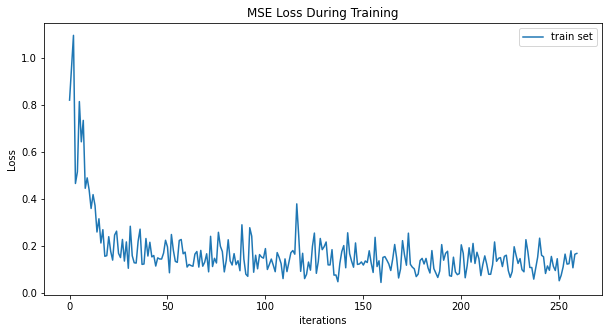

In [48]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
plt.plot(G_losses,label="train set")
# plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

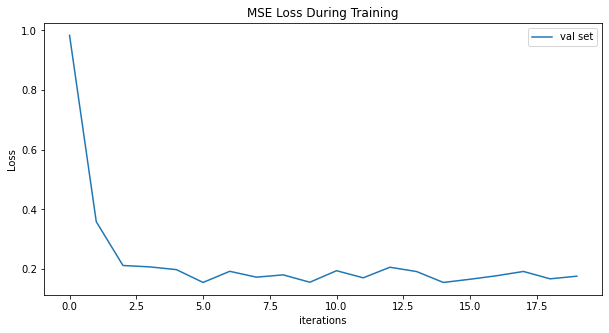

In [49]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
# plt.plot(G_losses,label="train set")
plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [50]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        fake = netG(data[0])
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [51]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [52]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,802.000000,802.000000
mean,-0.016723,0.086741
std,0.990411,0.951580
min,-1.002387,-0.987533
25%,-0.710780,-0.524221
50%,-0.351142,-0.203252
75%,0.242684,0.189137
max,3.860523,3.283279


In [53]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.989, -0.702]",-0.876809,-0.794338
"(-0.702, -0.585]",-0.800366,-0.640353
"(-0.585, -0.485]",-0.564334,-0.527849
"(-0.485, -0.341]",-0.511458,-0.415145
"(-0.341, -0.203]",-0.386895,-0.276039
"(-0.203, -0.0698]",-0.232238,-0.143276
"(-0.0698, 0.107]",-0.075603,0.010589
"(0.107, 0.421]",0.122715,0.222457
"(0.421, 1.646]",0.796159,0.902864


In [54]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.12642533, 0.9809145)

In [55]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.25807896, 0.7440123)

## Test Predictions

In [56]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        gen_ip = data[0] 
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [57]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [58]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,268.000000,268.000000
mean,-0.010279,0.129220
std,0.997585,0.992955
min,-1.001894,-0.976770
25%,-0.711990,-0.531245
50%,-0.286602,-0.154477
75%,0.239351,0.363726
max,3.246934,3.318184


In [59]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.978, -0.746]",-0.838193,-0.818506
"(-0.746, -0.638]",-0.807904,-0.694608
"(-0.638, -0.473]",-0.596673,-0.545093
"(-0.473, -0.328]",-0.541909,-0.395436
"(-0.328, -0.154]",-0.393618,-0.244273
"(-0.154, -0.0268]",-0.156356,-0.100547
"(-0.0268, 0.143]",-0.033099,0.068943
"(0.143, 0.617]",0.143404,0.347187
"(0.617, 1.956]",0.683426,1.060493


In [60]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.14245693, 0.9951752)

In [61]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.28319612, 0.73053676)

# Gaussian Process Regression

In [62]:
model = GaussianProcessRegressor(
    kernel=kernels.RBF(length_scale=0.05)
    ,n_restarts_optimizer=10
).fit(x[train], y[train])

/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [63]:
model.kernel_.get_params()

{'length_scale': 0.16136997595338018, 'length_scale_bounds': (1e-05, 100000.0)}

In [64]:
y_pred_gauss = model.predict(x[test])
y_true_gauss = y[test]
y_pred_gauss.mean(), y_true_gauss.mean(), y_pred_gauss.std(), y_true_gauss.std()

(-0.10634401615579091,
 -0.010278545110337028,
 0.5423521883775172,
 0.9957217851024796)

In [65]:
mean_absolute_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )
).mean()

(0.6551484040167926, 0.7305366892322611)

In [66]:
mean_squared_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )**2
).mean()

(0.9479208955857921, 0.9914618733276684)